![](images/notebook-images/knn-car-prices/two-cars.jfif){fig-align="center"}

<center><a href = "https://unsplash.com/photos/gKXKBY-C-Dk">Wheelscene | Chris Smith</a></center>

# Introduction

K Nearest Neighbors or KNN is an an algorithm that can make predictions based on the similarity between different observations. In this project, I used KNN to predict the price of a car based on how similar its features are to those of other cars. Towards this end, I applied various machine learning techniques, such as standardization, feature selection, train-test split, hyperparameter optimization, and k-fold cross validation.

:::{.callout-note}

I wrote this notebook by following a guided project on the [Dataquest](https://www.dataquest.io/) platform, specifically the [Guided Project: Predicting Car Prices](https://app.dataquest.io/c/36/m/155/guided-project%3A-predicting-car-prices/1/introduction-to-the-data-set). The general project flow and research questions were guided by Dataquest. Furthermore, though the mathematical explanations in this post were written in my own words, I learned the theory from Dataquest.

:::

Below are the packages used in this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_squared_error

# Data Inspection and Cleaning

The dataset for this project is the Automobile Data Set by Schlimmer (1987), from the UCI Machine Learning Repository. The data and its description can be obtained [here](https://archive.ics.uci.edu/ml/datasets/automobile).

The dataset describes 26 features of hundreds of cars. A summary of the features and their data types is shown below.

In [2]:
#| code-fold: true
# Data dictionary from documentation.
data_dict = """1. symboling: -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses: continuous from 65 to 256.
3. make:
alfa-romero, audi, bmw, chevrolet, dodge, honda,
isuzu, jaguar, mazda, mercedes-benz, mercury,
mitsubishi, nissan, peugot, plymouth, porsche,
renault, saab, subaru, toyota, volkswagen, volvo
4. fuel-type: diesel, gas.
5. aspiration: std, turbo.
6. num-of-doors: four, two.
7. body-style: hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels: 4wd, fwd, rwd.
9. engine-location: front, rear.
10. wheel-base: continuous from 86.6 120.9.
11. length: continuous from 141.1 to 208.1.
12. width: continuous from 60.3 to 72.3.
13. height: continuous from 47.8 to 59.8.
14. curb-weight: continuous from 1488 to 4066.
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders: eight, five, four, six, three, twelve, two.
17. engine-size: continuous from 61 to 326.
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore: continuous from 2.54 to 3.94.
20. stroke: continuous from 2.07 to 4.17.
21. compression-ratio: continuous from 7 to 23.
22. horsepower: continuous from 48 to 288.
23. peak-rpm: continuous from 4150 to 6600.
24. city-mpg: continuous from 13 to 49.
25. highway-mpg: continuous from 16 to 54.
26. price: continuous from 5118 to 45400."""

# Use regex to extract column names from data dictionary.
col_names = re.findall(
    pattern = r"^[0-9]{1,2}\. ([a-z\-]+):",
    string = data_dict,
    # Use multiline flag so that ^ indicates the start of a line.
    flags = re.MULTILINE,
)

# Read data file and add column names.
cars_df = pd.read_csv(
    "./private/Car-Prices-KNN-Files/imports-85.data",
    names = col_names,
)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

There are 205 cars and 26 features. Most of the features directly describe physical characteristics of the cars. Some exceptions are "symboling" and "normalized-losses", which are values related to car insurance and are beyond the scope of this project. Also, the "price" column provides the price of each car in USD.

Let us look at the first five rows.

In [3]:
#| code-fold: true
cars_df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


If we compare the data type of each column to its contents, several opportunities for data cleaning can be seen. For example, the "normalized-losses" feature is listed as an object-type column because it contains both strings and numbers. However, the strings in the column are question marks (?). Rather than being categories, these may be placeholders for missing data. This problem applies to several other columns, not just this one.

Furthermore, in some columns like "num-of-doors", numbers are written as words. For example, 2 is written as "two". Since the numbers are in string format, these cannot be used in the K Nearest Neighbors model.

Thus, in summary, the following cleaning steps have to be performed:

- Replace question mark strings ("?") with null values (NaN). These are the proper way to indicate missing values.
- Convert several object columns, like "normalized-losses", into numeric columns.
- Replace numbers written as words with their proper numeric equivalents. For example, replace "four" with 4.

These were performed in the following code cell.

In [4]:
#| code-fold: true
# Clean the data.

# Replace ? with NaN since these are placeholders.
cars_df = cars_df.replace("?", np.nan)

# Change this object column to float type.
obj_to_numeric = [
    "normalized-losses",
    "bore",
    "stroke",
    "horsepower",
    "peak-rpm",
    "price",
]

for col in obj_to_numeric:
    cars_df[col] = pd.to_numeric(cars_df[col], errors = "coerce")

# Replace strings with numeric equivalents.
cars_df["num-of-doors"] = cars_df["num-of-doors"].replace(
    {
        "four": 4.0,
        "two": 2.0,
    }
)
cars_df["num-of-cylinders"] = cars_df["num-of-cylinders"].replace(
    {
        "four": 4,
        "six": 6,
        "five": 5,
        "eight": 8,
        "two": 2,
        "three": 3,
        "twelve": 12,
    }
)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    float64
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    int64  
 16  engine-size        205 non

The new summary of columns is shown above. Several columns which were once "object" columns are now numeric. Also, since we replaced "?" placeholders with null values, we can now see that some columns have missing values.

In [5]:
#| code-fold: true
null_percs = (
    cars_df
    .isnull()
    .sum()
    .divide(cars_df.shape[0])
    .multiply(100)
)

null_percs.loc[null_percs > 0]

normalized-losses    20.00000
num-of-doors          0.97561
bore                  1.95122
stroke                1.95122
horsepower            0.97561
peak-rpm              0.97561
price                 1.95122
dtype: float64

The table above shows the percentage of missing values in each column that has them. In particular, "normalized-losses" has missing values in 20% of the observations. Thus, we will have to drop this column from the dataset. This is better than the alternative, which is to delete all rows where "normalized-losses" is missing.

As for the other 6 columns, we will use listwise deletion. This means that we will drop all rows with missing values in any of those columns.

In [6]:
#| code-fold: true
cars_df = (
    cars_df
    .drop("normalized-losses", axis = 1)
    .dropna(
        subset = [
            "num-of-doors",
            "bore",
            "stroke",
            "horsepower",
            "peak-rpm",
            "price",
        ]
    )
)

num_null = cars_df.isnull().sum().sum()
print(f"Total number of missing values: {num_null}")
print(f"New shape of dataset: {cars_df.shape}")

Total number of missing values: 0
New shape of dataset: (193, 25)


Now, there are no more missing values in the dataset. There are 193 rows and 25 columns left.

# The K Nearest Neighbors Algorithm

Next, I will discuss the theory behind the KNN algorithm, then implement it on the dataset.

First, let us discuss basic terminology. For your reference, below is a small part of the dataset:

In [7]:
#| code-fold: true
cars_df.loc[:5, ["make", "fuel-type", "num-of-doors", "body-style", "price"]]

,make,fuel-type,num-of-doors,body-style,price
0,alfa-romero,gas,2.0,convertible,13495.0
1,alfa-romero,gas,2.0,convertible,16500.0
2,alfa-romero,gas,2.0,hatchback,16500.0
3,audi,gas,4.0,sedan,13950.0
4,audi,gas,4.0,sedan,17450.0
5,audi,gas,2.0,sedan,15250.0


Each row of data is called an observation; in this case, each observation is a car.

On the other hand, each column is either a feature or a target. The target is the variable that we try to predict, and the features are information used to make the prediction. In the case of this project, the features may include the size of the car, the number of doors, etc. The target is the price of the car.

The set of cars whose prices we will predict is called the testing set. On the other hand, the training set is the set of cars used to train the model to make predictions. Put more simply, in order to predict the price of a car in the testing set, we must compare it to the cars in the training set.

In order to compare cars, KNN uses the Euclidean distance as a similarity metric between two observations. A low distance close to 0 means that the observations are very similar to each other. The following formula is used:

$d = \sqrt{\sum_{i=1}^n (q_i - p_i)^2}$

- $d$ is the Euclidean distance.
- $n$ is the number of features.
- $q$ and $p$ each refer to a different observation in the data. In this case, each is a different car. 
- $q_i$ is the value of feature $i$ for observation $q$. For example, if feature $1$ is the number of doors, $q_1$ is the number of doors on car $q$.
- The differences between the two observations' features are squared, then summed up. Finally, the square root of the sum gives the Euclidean distance.

Given that we want to predict the price of a car $q$, KNN computes the Euclidean distance of $q$ from *every single car in the training set*. The cars most similar to $q$ are its "nearest neighbors."

We then choose a number $k$, which will determine how many of the nearest neighbors will be selected. For example, if $k = 5$, we select the five most similar cars. Then, we take the mean price of these five cars, and we predict that this is the price of car $q$.

Since we make a prediction based on an observation's $k$ nearest neighbors, the algorithm is called K Nearest Neighbors. Note that what I have described is an example of a KNN regression model, as it predicts a numeric target. There are still several other forms of KNN. Some use a different similarity metric like Manhattan distance, and some perform classification, which means that they predict a categorical target (Miller, 2019).

# Techniques for Implementation

Unlike with my previous [post](2021-12-14-Naive-Bayes-Algorithm-Detecting-Spam-Messages.ipynb) on the Naive Bayes Algorithm, I will not be programming this algorithm manually. Instead, I will use the scikit-learn workflow, which involves pre-packaged machine learning functions.

In this part, I will individually discuss certain important techniques used in the machine learning workflow. In the next part, I will combine these techniques in order to obtain the optimal KNN model.

## Standardization

The first important technique is standardization. So that each feature will contribute equally to the Euclidean distance, we will standardize each numeric feature. In other words, each value will be converted into a z-score so that the mean of each feature is 0 and its standard deviation is 1. The following equation is used:

$z = \frac{x - \bar{x}}{s}$

- $z$ is the z-score.
- $x$ is a value in a feature.
- $\bar{x}$ is the mean of the feature.
- $s$ is the sample standard deviation.

In [8]:
#| code-fold: true
all_feature_cols = [col for col in cars_df.columns if col != "price"]

# Series of feature:data type
fdt = cars_df[all_feature_cols].dtypes

# Identify numeric features
all_numeric_features = fdt.index[fdt != "object"]

# Standardize
cars_df[all_numeric_features] = cars_df[all_numeric_features].apply(zscore, axis = 0, ddof = 1)

cars_df[all_numeric_features].head()

,symboling,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,1.782215,-1.172839,-1.678015,-0.442872,-0.839080,-2.117092,-0.025646,-0.410180,0.045098,0.511697,-1.803495,-0.287525,0.198054,-0.212806,-0.677292,-0.555613
1,1.782215,-1.172839,-1.678015,-0.442872,-0.839080,-2.117092,-0.025646,-0.410180,0.045098,0.511697,-1.803495,-0.287525,0.198054,-0.212806,-0.677292,-0.555613
2,0.163544,-1.172839,-0.719041,-0.250543,-0.184200,-0.613816,0.496473,1.544506,0.574066,-2.388614,0.701095,-0.287525,1.330822,-0.212806,-0.990387,-0.702307
3,0.972880,0.848214,0.142410,0.182198,0.143240,0.179580,-0.426254,-0.410180,-0.459826,-0.516262,0.479169,-0.036110,-0.039037,0.853987,-0.207649,-0.115531
4,0.972880,0.848214,0.077395,0.182198,0.236794,0.179580,0.498371,0.567163,0.189362,-0.516262,0.479169,-0.538940,0.303427,0.853987,-1.146935,-1.289083


The table above shows the first 5 rows of all of the numeric features. Notice that each feature now contains positive and negative values close to 0 because it was standardized.

## Feature Selection

The second technique is feature selection. We must choose features which we think are most relevant to a car's price. We can only select numeric features since categorical ones cannot be used to calculate Euclidean distance. Thus, we must select from the following features:

In [9]:
#| code-fold: true
all_numeric_features.to_list()

['symboling',
 'num-of-doors',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'num-of-cylinders',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg']

All of these features are physical characteristics of a car, except for "symboling". According to the dataset documentation by Schlimmer (2019), this feature is an "insurance risk rating." It elaborates:

> Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

Given that this feature is systematically associated with the price of a car, it may be relevant to our model. Thus, we will consider it along with the other numeric features.

In order to determine which combination of features is the best, we will use univariate feature selection. "Univariate" refers to the use of a single variable. We will perform a statistical test between each feature and the target. Then, we will select the features with the highest scores from the statistical test (scikit-learn developers, 2021).

In our case, we have a regression problem, since we want to predict a continuous variable, car price. Thus, we will use the F-statistic as our score function. According to Frost (2017), the F-statistic indicates the "overall significance" of a linear regression model. In univariate feature selection, we would do the following steps:

- For each feature:
    - Perform linear regression where the independent variable is the feature and the dependent variable is the target (in this case, price).
    - Obtain the F-statistic.
- Compile a list with the F-statistic of each feature.
- Identify the features with the highest F-statistics.

This can be implemented automatically using the scikit-learn's `SelectKBest` class. It is called `SelectKBest` because we can set a parameter `k` which tells how many features to select. For example, if `k = 3`, the top three features with the highest F-statistic are selected. This is done below:

In [10]:
#| code-fold: true
skb = SelectKBest(
    score_func = f_regression,
    k = 3,
)

X = cars_df[all_numeric_features]
y = cars_df["price"]

X_new = skb.fit_transform(X, y)

best_features = list(skb.get_feature_names_out())
print("Top 3 features:", best_features)

Top 3 features: ['curb-weight', 'engine-size', 'horsepower']


The results show that curb weight, engine size, and horsepower are the highest-scoring features. However, we will not select these yet for the final model, since other steps still must be discussed.

## Train-Test Split with Stratification

Train-test split is the third important technique.

Before model training, the dataset has to be split into training and testing sets. We will use 80% of the data in the training set and 20% in the testing set. As the names suggest, the training set is used to train the model or help it *learn* how to predict car prices. Then, we make predictions on the cars on the testing set to see whether the predictions are accurate.

Before we split the data, though, we have to ensure that the frequency distribution of the target is similar between the training and testing sets. Below is a histogram of the frequency distribution of car price across the entire dataset:

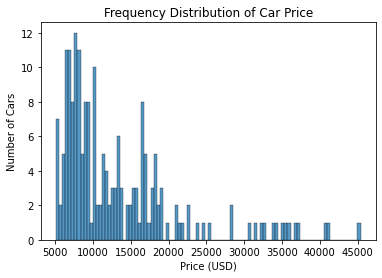

In [11]:
#| code-fold: true
sns.histplot(cars_df["price"], bins = 100)
plt.title("Frequency Distribution of Car Price")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Cars")
plt.show()

The graph shows a right-skewed distribution, which means that most of the car prices are low and there are outliers with high prices. When we split the data into training and testing sets, we want each set to have a similar distribution to this.

De Cock (2011) provides a helpful suggestion on how to do this. The article says, "Simply order the original data set by a variable of interest (such as 
sale price) and select every kth observation to achieve the desired sample size (k=2 for a 
50/50 split or k=4 for a 75/25 split)."

In our case, we want an 80/20 split. One-fifth of the data will go to the testing set, so we can use k = 5. We will thus order the observations by price, then assign every 5th observation to the testing set. All other observations will go to the training set.

In the code below, I have written a custom function `stratify_continuous` that uses this technique. I then performed a train-test split after stratification. `X_train` and `y_train` refer to the features and target in the training set, respectively. `X_test` and `y_test` are from the testing set.

In [12]:
#| code-fold: true

def stratify_continuous(n_folds, y):
    """Stratify a dataset on a continuous target."""
    if n_folds < 2 or n_folds > 10:
        raise ValueError("Please select a number of folds from 2 to 10.")
    
    fold_nums = list(range(n_folds))

    # DataFrame where "index" column contains the original indices
    df = pd.DataFrame(
        y
        # Shuffle before ranking so that cars with the same price are ordered randomly.
        .sample(frac = 1, random_state = 1, ignore_index = False)
    )

    # This column gives a rank to each value in y. 0 is the rank of the lowest value.
    # Ties are broken according to order of appearance.
    df["rank"] = df[y.name].rank(method = "first") - 1

    df["fold"] = 0

    for f in fold_nums[1:]:
        # start at f, then increment by n_folds
        indices = list(range(f, df.shape[0], n_folds))
        df.loc[df["rank"].isin(indices), "fold"] = f

    # Revert df to original order of indices
    df = df.reindex(index = y.index)

    # A series that indicates the fold number of each observation according to its original position in y
    fold_series = df["fold"].copy()

    return fold_series

folds = stratify_continuous(
    n_folds = 5,
    y = cars_df["price"],
)

def split_folds(X, y, fold_series, test_fold):
    """Take a dataset whose observations have been grouped into folds,
    then perform a train-test split."""

    if fold_series.dtype != "int64":
        raise AttributeError("The fold list does not purely contain integers.")

    test_mask = (fold_series == test_fold)

    X_train = X.loc[~test_mask].copy()
    y_train = y.loc[~test_mask].copy()

    X_test = X.loc[test_mask].copy()
    y_test = y.loc[test_mask].copy()

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_folds(
    X = cars_df[all_numeric_features],
    y = cars_df["price"],
    fold_series = folds,
    test_fold = 4,
)

# Summary statistics for target columns.
target_df = pd.concat(
    [y_train, y_test],
    axis = 1,
    join = "outer",
)

target_df.columns = ["y_train price", "y_test price"]

target_df.describe()

,y_train price,y_test price
count,155.000000,38.000000
mean,13308.658065,13188.631579
std,8197.063090,7737.592975
min,5118.000000,5389.000000
25%,7713.500000,7805.750000
50%,10245.000000,10295.000000
75%,16530.500000,16385.750000
max,45400.000000,37028.000000


This table shows summary statistics for the price columns of the two sets. The sets have similar means at around USD 13,200, and they also have similar medians at around USD 10,200.

Let us compare the price distributions using KDE plots:

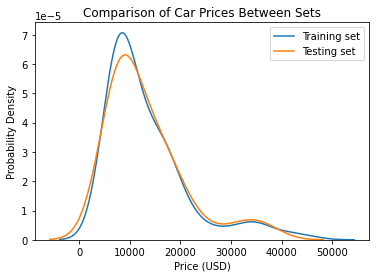

In [13]:
#| code-fold: true
sns.kdeplot(y_train, label = "Training set")
sns.kdeplot(y_test, label = "Testing set")

plt.title("Comparison of Car Prices Between Sets")
plt.xlabel("Price (USD)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

The KDE plots both seem to follow the same shape and have the same center. This shows that the training and testing sets have roughly the same distribution of car prices. Thus, these were stratified correctly.

## Hyperparameter Optimization

The fourth technique is hyperparameter optimization. This involves training the KNN model using different hyperparameter values to see which one performs the best.

A hyperparameter is a value that influences the behavior of a model and has no relation to the data. In the case of KNN, one important hyperparameter is the $k$ value, or the number of neighbors used to make a prediction. If $k = 5$, we take the mean price of the top five most similar cars and call this our prediction. However, if $k = 10$, we take the top ten cars, so the mean price may be different.

We can optimize $k$ in this way:

- Decide values of $k$ to test.
- For each $k$ value, fit and evaluate a KNN model.
- Identify the best-performing model and use its $k$ value in the final model.

In order to evaluate a model, we need an evaluation metric. In our case, we will use the Root Mean Squared Error or RMSE. This is calculated with the following equation:

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\text{actual}_i - \text{predicted}_i)^2}$

- $n$ is the sample size.
- $\text{actual}$ is the actual target value, or in this case, the actual price of a car.
- $\text{predicted}$ is the predicted target value.

RMSE can be interpreted as the average error of a regression model. For example, if $RMSE = 1000$, this means that the model's predicted car prices are USD 1000 away from the actual car prices, on average.

Below is an example of hyperparameter optimization using RMSE. All of the numeric features were used for this example.

In [14]:
#| code-fold: true

k_values = [1, 3, 5]

k_rmse = pd.Series(dtype = "float64")

for k in k_values:
    knn = KNeighborsRegressor(
        n_neighbors = k,
        algorithm = "auto",
    )

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    k_rmse.loc[k] = rmse

print("k value and RMSE")
k_rmse

k value and RMSE


1    4086.029491
3    3146.025226
5    3251.392477
dtype: float64

The table above shows that RMSE was lowest for $k = 3$. The RMSE was about USD 3146, which means that on average, the predicted prices are USD 3146 away from the actual prices.

## K-Fold Cross-Validation

The last technique that will be discussed is K-Fold Cross-Validation. Earlier, we split the data into one training set and one testing set. The K-Fold Cross-Validation allows us to obtain a more holistic view of model performance by rotating the observations used in the two sets. In the words of Brownlee (2018), it estimates "how the model is expected to perform in general when used to make predictions on data not used during the training of the model."

Here, $k$ has a different meaning. It determines the number of splits to make in a dataset. For example, if $k = 5$, the dataset will be split into 5 folds, each set containing 20% of the total data.

In summary, the following steps are performed:

- Split the data into 5 folds: A, B, C, D, E.
- Use fold A as the testing set and use the others as the training set.
- Fit and evaluate a KNN model, thus obtaining RMSE.
- Repeat the above process for a total of 5 times, so that each fold is used as a testing set once.
- Compile a list of the five RMSE values obtained.
- Compute the mean RMSE value. This is the final metric of model performance.

K-Fold Cross-Validation can be implemented using scikit-learn's `KFold` and `cross_val_score` . An example of 5-fold cross-validation is shown below.

In [15]:
#| code-fold: true

knn = KNeighborsRegressor(
    n_neighbors = 5,
    algorithm = "auto",
)

kf = KFold(5, shuffle = True, random_state = 1)

mses = cross_val_score(
    estimator = knn,
    X = cars_df[all_numeric_features],
    y = cars_df["price"],
    scoring = "neg_mean_squared_error",
    cv = kf,
)

mses = pd.Series(mses)

rmses = mses.abs().pow(1/2)

mean_rmse = rmses.mean()

sd_rmse = rmses.std(ddof = 1)

print(f"""Regular 5-fold cross-validation
Mean RMSE: {mean_rmse:.2f}
Standard Deviation RMSE: {sd_rmse:.2f}
RMSE Values: {rmses.to_list()}""")

Regular 5-fold cross-validation
Mean RMSE: 3722.28
Standard Deviation RMSE: 565.62
RMSE Values: [3407.8275635020186, 3902.1144860913682, 3009.7340988268425, 4521.314079941105, 3770.3892479494248]


The mean RMSE above presents a better picture of the model's performance because it takes into account different possible combinations of training and testing sets.

Note, however, that the standard deviation of the RMSE was around 566. This means that the RMSE values varied by several hundreds of dollars from model to model during the cross-validation. In simpler terms, the model performance was inconsistent. It performed much better when trained on some folds than when it was trained on other folds.

Thus, we can take k-fold cross-validation a step further by stratifying the folds so that they will have similar price distributions. This will ensure that each fold is representative of the full sample. Thus, I have written a custom function in the code cell below to do this.

In [16]:
#| code-fold: true
def stratified_kfcv(X, y, fold_series, regression_model):
    """Conduct k-fold cross-validation on a stratified dataset."""

    fold_nums = fold_series.unique()

    mse_lst = []

    for f in fold_nums:
        X_train, X_test, y_train, y_test = split_folds(
            X = X,
            y = y,
            test_fold = f,
            fold_series = fold_series,
        )
        
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mse_lst.append(mse)

    return mse_lst

knn = KNeighborsRegressor(
    n_neighbors = 5,
    algorithm = "auto",
)

mse_lst = stratified_kfcv(
    X = cars_df[all_numeric_features],
    y = cars_df["price"],
    fold_series = folds,
    regression_model = knn,
)

mse_series = pd.Series(mse_lst)

rmse_series = mse_series.pow(1/2)

mean_rmse = rmse_series.mean()
sd_rmse = rmse_series.std(ddof = 1)

print(f"""Stratified 5-fold cross-validation
Mean RMSE: {mean_rmse:.2f}
Standard Deviation RMSE: {sd_rmse:.2f}
RMSE Values: {rmse_series.to_list()}""")

Stratified 5-fold cross-validation
Mean RMSE: 3369.44
Standard Deviation RMSE: 387.33
RMSE Values: [3193.0727214096655, 2883.515369146238, 3844.6421242541865, 3674.5947449327227, 3251.39247707809]


The mean RMSE from stratified CV was USD 3369. This is about USD 400 lower than the result of the regular CV, USD 3722.

Furthermore, the SD RMSE is equal to 387, which is lower than the previous value of 566. Therefore, the five models trained during cross-validation performed more similarly to each other.

Thus, we can see that stratifying observations before k-fold cross-validation can be more effective at approximating the true performance of the model compared to regular k-fold cross-validation.

# Combining Techniques

In this part, we will combine all of the discussed techniques to optimize the KNN model.

The steps are as follows:

- Use the standardized features that were calculated earlier.
- For each number `n_features` from 1 to 10:
    - Perform univariate feature selection using the F-statistic.
    - Identify the best `n_features` features.
    - For each number `k` from 1 to 20:
        - Evaluate the model using stratified 5-fold cross-validation.
        - For each fold, train a `k` nearest neighbors model using the best features.
        - Obtain the mean RMSE value.
- Compile a list of all mean RMSE values obtained.
- Identify the model with the lowest mean RMSE. This is the final model.

This is implemented in the code below.

In [17]:
#| code-fold: true
n_feature_list = list(range(1, 11))

result_lst = []

for n_features in n_feature_list:
    
    # Univariate feature selection
    skb = SelectKBest(
        score_func = f_regression,
        k = n_features,
    )

    X = cars_df[all_numeric_features]
    y = cars_df["price"]

    X_new = skb.fit_transform(X, y)

    # List of "best" features
    best_features = list(skb.get_feature_names_out())

    k_values = list(range(1, 21))

    for k in k_values:

        # stratified 5-fold cross validation

        knn = KNeighborsRegressor(
            # Use a different k value each time
            n_neighbors = k,
            algorithm = "auto",
        )

        mse_lst = stratified_kfcv(
            X = cars_df[best_features],
            y = cars_df["price"],
            fold_series = folds,
            regression_model = knn,
        )

        mse_series = pd.Series(mse_lst)

        rmse_series = mse_series.pow(1/2)

        mean_rmse = rmse_series.mean()
        sd_rmse = rmse_series.std(ddof = 1)

        new_row = (n_features, best_features, k, mean_rmse, sd_rmse)
        result_lst.append(new_row)

result_df = pd.DataFrame(result_lst)
result_df.columns = ["Number of Features", "Best Features", "k Neighbors", "Mean RMSE", "SD RMSE"]

result_df = (
    result_df
    .sort_values(["Mean RMSE", "SD RMSE"], ascending = True)
    .reset_index(drop = True)
)

Before we discuss the top-performing models, let us look at the general trends in the results using some graphs.

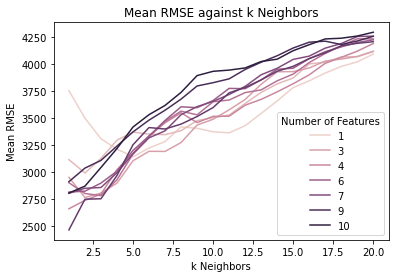

In [18]:
#| code-fold: true
sns.lineplot(
    data = result_df,
    x = "k Neighbors",
    y = "Mean RMSE",
    hue = "Number of Features",
)

plt.title("Mean RMSE against k Neighbors")
plt.show()

The graph above shows that in general, no matter the number of features, the mean RMSE increased as the number of neighbors (k) increased. Therefore, it is best to have a low k value so that the model makes predictions only using a few cars that are most similar to the car being tested.

Next, let us look at a graph with the same variables, except that the number of features is now on the x-axis instead of k.

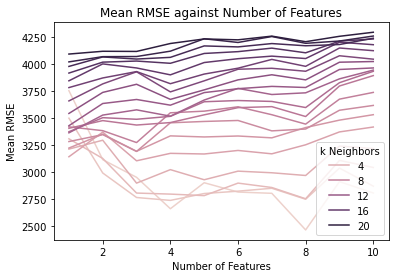

In [19]:
#| code-fold: true
sns.lineplot(
    data = result_df,
    x = "Number of Features",
    y = "Mean RMSE",
    hue = "k Neighbors",
)

plt.title("Mean RMSE against Number of Features")
plt.show()

We can see that for models with a high k value (represented by the darker lines), the mean RMSE increased slightly as the number of features increased.

However, for models with a low k value (represented by the lighter pink lines), the mean RMSE stayed the same or even decreased when the number of features increased.

Therefore, the best model would be one with a low k value and a medium-to-high number of features.

In order to determine this more precisely, let us look at the top 10 models with the lowest RMSE.

In [20]:
#| code-fold: true
result_df.head(10)

,Number of Features,Best Features,k Neighbors,Mean RMSE,SD RMSE
0,8,"[length, width, curb-weight, num-of-cylinders,...",1,2468.363493,354.699226
1,4,"[width, curb-weight, engine-size, horsepower]",1,2663.935533,809.240758
2,4,"[width, curb-weight, engine-size, horsepower]",2,2740.846793,541.902963
3,8,"[length, width, curb-weight, num-of-cylinders,...",2,2751.669830,693.467197
4,8,"[length, width, curb-weight, num-of-cylinders,...",3,2755.824129,383.365351
5,3,"[curb-weight, engine-size, horsepower]",2,2767.545024,543.282005
6,5,"[width, curb-weight, num-of-cylinders, engine-...",3,2784.838645,450.626647
7,4,"[width, curb-weight, engine-size, horsepower]",3,2798.859095,477.298250
8,5,"[width, curb-weight, num-of-cylinders, engine-...",2,2804.311055,473.482127
9,7,"[width, curb-weight, num-of-cylinders, engine-...",1,2806.166008,696.001235


The table above shows the ten models with the lowest mean RMSE. Interestingly, the best-performing model had 8 features and a k-value of 1.

Its RMSE was 2468, so on average, the predicted prices were USD 2468 off from the actual prices. This is decent considering that the car prices mostly fall between USD 5000 and USD 20000, though it could be better.

The SD RMSE is around 355. This means that the RMSE values usually varied by 355 from the mean. This is relatively low compared to the SD RMSE values of the other best-performing models, which range from 350 to over 800. Therefore, the model performance was consistent.

However, the following concerns are worth noting:

- The number of features is somewhat large, and this may be a problem because it can cause overfitting. This means that the model may be too sensitive to small but meaningless variations in the training data. It may be unable to recognize *general trends* properly. However, reducing the number of features may increase the mean RMSE.
- The k-value is concerning because only one neighbor is considered when predicting a car's price. I would prefer to have $k > 1$ so that multiple neighbors are taken into consideration.

Personally, I am fine with selecting this model as the final one to use, simply because its mean RMSE is a few hundred dollars lower than that of the other good models. In a real-world scenario, after I implement this model, I would see if it continued to perform well on new data, and then reduce its number of features or increase its k-value if needed.

# Summary

In this project, we cleaned a dataset about car features and prices, discussed the logic behind the K Nearest Neighbors algorithm for regression, explained techniques used in the machine learning workflow, then applied these techniques to determine the optimal model for predicting car prices.

Thanks for reading!

# Bibliography

## Data Source

Schlimmer, J. C. (1987, May 19). UCI Machine Learning Repository: Automobile Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/automobile

## Information Sources

Brownlee, J. (2018, May 22). A Gentle Introduction to k-fold Cross-Validation. Machine Learning Mastery. https://machinelearningmastery.com/k-fold-cross-validation/

Dataquest. (n.d.). Predicting Car Prices: Machine Learning Project. Dataquest. Retrieved December 21, 2021, from https://www.dataquest.io/c/36/m/155/guided-project%3A-predicting-car-prices

De Cock, D. (2011). Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project. Journal of Statistics Education, 19(3), null. https://doi.org/10.1080/10691898.2011.11889627

Frost, J. (2017, April 4). How to Interpret the F-test of Overall Significance in Regression Analysis. Statistics By Jim. http://statisticsbyjim.com/regression/interpret-f-test-overall-significance-regression/

Miller, M. (2019, October 18). The Basics: KNN for classification and regression. Medium. https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955

scikit-learn developers. (2021). 1.13.2. Univariate Feature Selection. Scikit-Learn. https://scikit-learn/stable/modules/feature_selection.html

## Image Source

Smith, C. (2018, January 20). Charger vs Challenger: All-American Muscle Car Comparison. WheelScene. https://wheelscene.com/charger-vs-challenger/